In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import importlib
sys.path.insert(1, '../../../sibyl')

In this tutorial, we use Sibyl to get feature contribution explanations for the AmesHousing dataset

First, we load in the data. Sibyl expects all data as DataFrames, where columns have the feature names.

In [7]:
data = pd.read_csv("data.csv")
data = data[data.GrLivArea < 4000]
y_orig = data["SalePrice"]
x_orig = data.drop("SalePrice", axis="columns")
print(x_orig.shape, y_orig.shape)

(1456, 80) (1456,)


Next, we load in the interpretable feature descriptions.

In [8]:
descriptions_df = pd.read_csv("feature_descriptions.csv")
descriptions = descriptions_df.set_index("Name").to_dict()["Description"]

Next, we prepare the transfomers. There are three kinds of transformers: e_transforms, m_transforms, and i_transforms. In this case, the original data is already interpretable, and the explanation algorithm will take the data in its model_ready form.

Therefore, i_transforms=None and e_transforms=m_transforms.

The first kind of transform we will do it to manually impute the data based on information we know about the dataset.
We will call this the `AmesHousingImputer`

This imputation code comes from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [9]:
from sibyl.utils.transformer import BaseTransformer
class AmesHousingImputer:
    def transform(self, x_orig):
            x_transform = x_orig.copy()
            # Alley : data description says NA means "no alley access"
            x_transform.loc[:, "Alley"] = x_transform.loc[:, "Alley"].fillna("None")
            # BedroomAbvGr : NA most likely means 0
            x_transform.loc[:, "BedroomAbvGr"] = x_transform.loc[:, "BedroomAbvGr"].fillna(0)
            # BsmtQual etc : x_transform description says NA for basement features is "no basement"
            x_transform.loc[:, "BsmtQual"] = x_transform.loc[:, "BsmtQual"].fillna("No")
            x_transform.loc[:, "BsmtCond"] = x_transform.loc[:, "BsmtCond"].fillna("No")
            x_transform.loc[:, "BsmtExposure"] = x_transform.loc[:, "BsmtExposure"].fillna("No")
            x_transform.loc[:, "BsmtFinType1"] = x_transform.loc[:, "BsmtFinType1"].fillna("No")
            x_transform.loc[:, "BsmtFinType2"] = x_transform.loc[:, "BsmtFinType2"].fillna("No")
            x_transform.loc[:, "BsmtFullBath"] = x_transform.loc[:, "BsmtFullBath"].fillna(0)
            x_transform.loc[:, "BsmtHalfBath"] = x_transform.loc[:, "BsmtHalfBath"].fillna(0)
            x_transform.loc[:, "BsmtUnfSF"] = x_transform.loc[:, "BsmtUnfSF"].fillna(0)
            # CentralAir : NA most likely means No
            x_transform.loc[:, "CentralAir"] = x_transform.loc[:, "CentralAir"].fillna("N")
            # Condition : NA most likely means Normal
            x_transform.loc[:, "Condition1"] = x_transform.loc[:, "Condition1"].fillna("Norm")
            x_transform.loc[:, "Condition2"] = x_transform.loc[:, "Condition2"].fillna("Norm")
            # EnclosedPorch : NA most likely means no enclosed porch
            x_transform.loc[:, "EnclosedPorch"] = x_transform.loc[:, "EnclosedPorch"].fillna(0)
            # External stuff : NA most likely means average
            x_transform.loc[:, "ExterCond"] = x_transform.loc[:, "ExterCond"].fillna("TA")
            x_transform.loc[:, "ExterQual"] = x_transform.loc[:, "ExterQual"].fillna("TA")
            # Fence : x_transform description says NA means "no fence"
            x_transform.loc[:, "Fence"] = x_transform.loc[:, "Fence"].fillna("No")
            # FireplaceQu : x_transform description says NA means "no fireplace"
            x_transform.loc[:, "FireplaceQu"] = x_transform.loc[:, "FireplaceQu"].fillna("No")
            x_transform.loc[:, "Fireplaces"] = x_transform.loc[:, "Fireplaces"].fillna(0)
            # Functional : x_transform description says NA means typical
            x_transform.loc[:, "Functional"] = x_transform.loc[:, "Functional"].fillna("Typ")
            # GarageType etc : x_transform description says NA for garage features is "no garage"
            x_transform.loc[:, "GarageType"] = x_transform.loc[:, "GarageType"].fillna("No")
            x_transform.loc[:, "GarageFinish"] = x_transform.loc[:, "GarageFinish"].fillna("No")
            x_transform.loc[:, "GarageQual"] = x_transform.loc[:, "GarageQual"].fillna("No")
            x_transform.loc[:, "GarageCond"] = x_transform.loc[:, "GarageCond"].fillna("No")
            x_transform.loc[:, "GarageArea"] = x_transform.loc[:, "GarageArea"].fillna(0)
            x_transform.loc[:, "GarageCars"] = x_transform.loc[:, "GarageCars"].fillna(0)
            # HalfBath : NA most likely means no half baths above grade
            x_transform.loc[:, "HalfBath"] = x_transform.loc[:, "HalfBath"].fillna(0)
            # HeatingQC : NA most likely means typical
            x_transform.loc[:, "HeatingQC"] = x_transform.loc[:, "HeatingQC"].fillna("TA")
            # KitchenAbvGr : NA most likely means 0
            x_transform.loc[:, "KitchenAbvGr"] = x_transform.loc[:, "KitchenAbvGr"].fillna(0)
            # KitchenQual : NA most likely means typical
            x_transform.loc[:, "KitchenQual"] = x_transform.loc[:, "KitchenQual"].fillna("TA")
            # LotFrontage : NA most likely means no lot frontage
            x_transform.loc[:, "LotFrontage"] = x_transform.loc[:, "LotFrontage"].fillna(0)
            # LotShape : NA most likely means regular
            x_transform.loc[:, "LotShape"] = x_transform.loc[:, "LotShape"].fillna("Reg")
            # MasVnrType : NA most likely means no veneer
            x_transform.loc[:, "MasVnrType"] = x_transform.loc[:, "MasVnrType"].fillna("None")
            x_transform.loc[:, "MasVnrArea"] = x_transform.loc[:, "MasVnrArea"].fillna(0)
            # MiscFeature : x_transform description says NA means "no misc feature"
            x_transform.loc[:, "MiscFeature"] = x_transform.loc[:, "MiscFeature"].fillna("No")
            x_transform.loc[:, "MiscVal"] = x_transform.loc[:, "MiscVal"].fillna(0)
            # OpenPorchSF : NA most likely means no open porch
            x_transform.loc[:, "OpenPorchSF"] = x_transform.loc[:, "OpenPorchSF"].fillna(0)
            # PavedDrive : NA most likely means not paved
            x_transform.loc[:, "PavedDrive"] = x_transform.loc[:, "PavedDrive"].fillna("N")
            # PoolQC : x_transform description says NA means "no pool"
            x_transform.loc[:, "PoolQC"] = x_transform.loc[:, "PoolQC"].fillna("No")
            x_transform.loc[:, "PoolArea"] = x_transform.loc[:, "PoolArea"].fillna(0)
            # SaleCondition : NA most likely means normal sale
            x_transform.loc[:, "SaleCondition"] = x_transform.loc[:, "SaleCondition"].fillna("Normal")
            # ScreenPorch : NA most likely means no screen porch
            x_transform.loc[:, "ScreenPorch"] = x_transform.loc[:, "ScreenPorch"].fillna(0)
            # TotRmsAbvGrd : NA most likely means 0
            x_transform.loc[:, "TotRmsAbvGrd"] = x_transform.loc[:, "TotRmsAbvGrd"].fillna(0)
            # Utilities : NA most likely means all public utilities
            x_transform.loc[:, "Utilities"] = x_transform.loc[:, "Utilities"].fillna("AllPub")
            # WoodDeckSF : NA most likely means no wood deck
            x_transform.loc[:, "WoodDeckSF"] = x_transform.loc[:, "WoodDeckSF"].fillna(0)
            x_transform.loc[:, "Electrical"] = x_transform.loc[:, "Electrical"].fillna("SBrkr")
            
            x_num = x_transform.select_dtypes(exclude=["object"])
            x_cat = x_transform.select_dtypes(include=["object"])
            x_num = x_num.fillna(x_num.median())
            
            return pd.concat([x_num, x_cat], axis=1)

Next, we need to one-hot-encode the categorical variables. 

We will now fit the tranformers.

In [10]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sibyl.utils.transformer import OneHotEncoderWrapper, DataFrameWrapper

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

imputer = AmesHousingImputer()
X_imputed = imputer.transform(X_orig)

object_columns = X_imputed.select_dtypes(include=["object"]).columns
onehotencoder = OneHotEncoderWrapper(object_columns)
onehotencoder.fit(X_imputed)

Now, we can initialize the LocalFeatureContribution Explainer object.

In [12]:
from sibyl.explainers import local_feature_explanation
importlib.reload(local_feature_explanation)

m_transforms = [imputer, onehotencoder]#, standardizer]
lfc = local_feature_explanation.LocalFeatureContribution(model_pickle_filepath="model.pkl", 
                                                         x_orig=x_orig, e_transforms=m_transforms,
                                                         m_transforms=m_transforms,
                                                         contribution_transformers=onehotencoder,
                                                         feature_descriptions=descriptions)

We can make predictions using Explainer objects.

0.008441633093187613


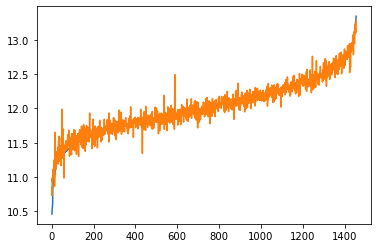

In [13]:
import matplotlib.pyplot as plt

preds = lfc.model_predict(X_orig).reshape(-1)
print(np.mean((preds - np.log1p(y_orig))**2))

sort_order = np.argsort(y_orig)

x_axis = np.arange(len(y_orig))
plt.plot(x_axis, np.log1p(y_orig).iloc[sort_order])
plt.plot(x_axis, preds[sort_order])
plt.show()


In [14]:
lfc.fit()

Finally, we can get contributions.

In [27]:
contributions = lfc.produce(X_orig.iloc[0:1])
top = contributions.sort_values(by=0, axis=1, ascending=False).iloc[:,:5]

print("Top contributing features: ")
for item in top:
    print(item, "-", top[item].values[0])

Top contributing features: 
 Original construction date - 0.05580365888113566
 Above grade (ground) living area square feet - 0.03817861922964804
 Rates the overall material and finish of the house - 0.037354510925780335
 Second floor square feet - 0.033370651850874906
 Remodel date (same as construction date if no remodeling or additions) - 0.014872988666617903
 Type 1 finished square feet - 0.01467236000170283
 Rating of basement finished area - 0.013872438050575647
 Basement full bathrooms - 0.013297920139855769
 Heating quality and condition - 0.012879596452316908
 Type of foundation - 0.012843783325508368
 Half baths above grade - 0.012774899651546564
 Condition of sale - 0.010201565015779995
 Identifies the general zoning classification of the sale. - 0.00861985358841419
 Exterior covering on house (if more than one material) - 0.008193244444100082
 Proximity to various conditions - 0.007351846216604659
 Full bathrooms above grade - 0.0071663528058205205
 Size of garage in car ca